In [4]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
data = pd.read_csv('../data_with_state.csv')

# Convert the 'time' column to datetime and sort the data by time
data['time'] = pd.to_datetime(data['time'], format='%d-%m-%Y')
data = data.sort_values('time')

# Select features and target
features = ['lat', 'lon', 'rtzsm_inst', 'sfsm_inst', 'week_no']
target = 'gws_inst'

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[features + [target]])


In [5]:

# Function to create sequences for Transformer
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length, :-1])  # All features except target
        ys.append(data[i+seq_length, -1])     # Target column (gws_inst)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 60  # Experiment with sequence length
X, y = create_sequences(data_scaled, SEQ_LENGTH)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# Transformer model parameters
d_model = 64  # Dimension of embedding
num_heads = 4  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed-forward network
dropout_rate = 0.2

# Build the Transformer model
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-Head Self Attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + inputs)

    # Feed Forward layer
    ff_output = Dense(ff_dim, activation="relu")(attention_output)
    ff_output = Dropout(dropout)(ff_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
   
    return LayerNormalization(epsilon=1e-6)(ff_output + attention_output)


In [7]:

# Input shape: (SEQ_LENGTH, number of features)
inputs = Input(shape=(SEQ_LENGTH, X_train.shape[2]))

# Transformer encoder block
x = transformer_encoder(inputs, head_size=d_model, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout_rate)

# Global Average Pooling to collapse sequence dimension
x = Dense(20, activation="relu")(x)
x = Dropout(0.2)(x)

# Output layer for regression
outputs = Dense(1)(x)

# Define the model
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=10,
                    batch_size=32,
                    callbacks=[early_stopping])


Epoch 1/10
8544/8544 ━━━━━━━━━━━━━━━━━━━━ 399s 44ms/step - loss: 0.1787 - val_loss: 0.1355
Epoch 2/10
8544/8544 ━━━━━━━━━━━━━━━━━━━━ 383s 44ms/step - loss: 0.1370 - val_loss: 0.1353
Epoch 3/10
8544/8544 ━━━━━━━━━━━━━━━━━━━━ 308s 36ms/step - loss: 0.1359 - val_loss: 0.1353
Epoch 4/10
8544/8544 ━━━━━━━━━━━━━━━━━━━━ 342s 40ms/step - loss: 0.1352 - val_loss: 0.1353
Epoch 5/10
8544/8544 ━━━━━━━━━━━━━━━━━━━━ 298s 35ms/step - loss: 0.1348 - val_loss: 0.1353
Epoch 6/10
8544/8544 ━━━━━━━━━━━━━━━━━━━━ 253s 27ms/step - loss: 0.1346 - val_loss: 0.1354
Epoch 7/10
8544/8544 ━━━━━━━━━━━━━━━━━━━━ 250s 25ms/step - loss: 0.1348 - val_loss: 0.1353
Epoch 8/10
8544/8544 ━━━━━━━━━━━━━━━━━━━━ 211s 25ms/step - loss: 0.1351 - val_loss: 0.1353
Epoch 9/10
8544/8544 ━━━━━━━━━━━━━━━━━━━━ 257s 24ms/step - loss: 0.1348 - val_loss: 0.1353
Epoch 10/10
8544/8544 ━━━━━━━━━━━━━━━━━━━━ 214s 25ms/step - loss: 0.1345 - val_loss: 0.1353


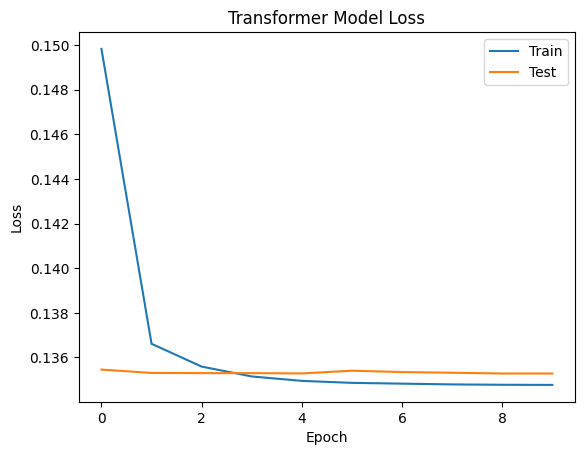

In [8]:

# Plot training & validation loss.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Transformer Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


In [9]:

# Make predictions on the test set
predictions = model.predict(X_test)


2136/2136 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step


In [10]:

# Rescale the predictions back to the original scale
y_test_rescaled = scaler.inverse_transform(np.concatenate([X_test[:, -1], y_test.reshape(-1,1)], axis=1))[:, -1]
predictions_rescaled = scaler.inverse_transform(np.concatenate([X_test[:, -1], predictions], axis=1))[:, -1]


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 3 dimension(s)

In [ ]:

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual Groundwater Storage')
plt.plot(predictions_rescaled, label='Predicted Groundwater Storage', alpha=0.7)
plt.title('Transformer: Actual vs Predicted Groundwater Storage')
plt.xlabel('Samples')
plt.ylabel('Groundwater Storage')
plt.legend()
plt.show()